In [155]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.feature import NaturalEarthFeature
from matplotlib import colors
from functools import reduce
import cftime as cf
import regionmask
import geopandas as gp
import matplotlib.patheffects as pe
import pooch
from IPython.display import Markdown

# Is there a difference between total sectoral withdrawal in the LND and ROF components?
While the demand for irrigation and other sectors is computed in the land component (LND) of the model, the supply come from the routing component (ROF), and notably from the river network storage.
Since the LND and ROF components have different grids, there is a need to properly connect the demand and supply part through the coupler. This is done through a mapping procedure from LND -> ROF fluxes.

Another important challenge to consider, is that the multiple ROF cells which overlap with a given LND cell, may have very different amount of water stored in the river (VOLR).
It makes sense therefore to distribute the demand load (from LND cell), onto the ROF cells in proportion to their water storage. 
If we take more water from ROF cells with higher VOLR, we are more likely to avoid the situation in which we try to withdraw more that it is available in any given ROF cell.
In this case we will not be invoking the protection algorithm which provides missing water from ocean, an unrealistic situation to be avoided.

The currently implemented mapping procedure goes as follow:
1) Normalize a given LND cell demand flux by the available VOLR in that LND cell
2) Mapping this VOLR-normalized demand flux to the ROF grid
3) Convert the VOLR-normalized demand flux back to normal flux on the ROF grid

If the remapping procedure is correct, we should expect that when we aggregate at global or continental level, the total actual withdrawal seen by the LND and ROF model should be the same.
In this notebook I am testing this hypothesis, first for irrigation, and then for other sectors which used the same remaping procedure.


In [149]:
# unit transform constants
seconds_per_day = 86400.0
avg_days_per_month_year_2000 = 366.0/12
mm_per_s_to_mm_per_month = seconds_per_day*avg_days_per_month_year_2000

m_to_mm = 1000.0

# Since ROF provides the withdrawal fluxes as m3/s, we need to divide by each grid area to obtain the fluxes as mm/s
# The MOSART provides 3 outputs for area. From these 3, I found that only 'areatotal2' provides the right magnitude of withdrawal fluxes when compared to the LND fluxes (but I am not 100% if this is the right area values to use)
area_rof       =  xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/rof/hist/selected_data/area/area_rof.nc', decode_times=False)['area'].values.flatten() # runoff grid area
areatotal_rof  =  xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/rof/hist/selected_data/area/areatotal_rof.nc', decode_times=False)['areatotal'].values.flatten() # basin upstream areatotal
areatotal2_rof =  xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/rof/hist/selected_data/area/areatotal2_rof.nc', decode_times=False)['areatotal2'].values.flatten() # computed basin upstream areatotal

area_lnd =  xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/lnd/hist/selected_data/area/area_lnd.nc', decode_times=False)['area'].values.flatten()*(1000*1000) # transform from km2 to m2

print(np.nansum(area_rof))
print(np.nansum(areatotal_rof))
print(np.nansum(areatotal2_rof))
print(np.nansum(area_lnd))

rof_m3_per_s_to_mm_per_s = (1.0/areatotal2_rof)*m_to_mm

510099707658239.94
2452661321501696.5
2903971568912507.0
166948792890380.88


In [150]:
# Load lon and lat coordinates for lnd and rof components
lnd_lon = xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/lnd/hist/selected_data/aggregated_data/selected_variables.ctsm_escomp_irrig_rof_limited.clm2.h0.2000.nc')['lon'].values
lnd_lat = xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/lnd/hist/selected_data/aggregated_data/selected_variables.ctsm_escomp_irrig_rof_limited.clm2.h0.2000.nc')['lat'].values

rof_lon = xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/rof/hist/selected_data/aggregated_data/selected_variables.ctsm_escomp_irrig_rof_limited.mosart.h0.2000.nc')['lon'].values
rof_lat = xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/rof/hist/selected_data/aggregated_data/selected_variables.ctsm_escomp_irrig_rof_limited.mosart.h0.2000.nc')['lat'].values

In [151]:
# Load the irrigation data from land model
# The data is obtained from a simulation with: irrigate=.true. and limit_irrigation_if_rof_enabled=.true.
# Transform from mm/s to mm/year
# We get mm/year instead of mm/month because we also sum over 12 months of year 2000
lnd_irrig_withd = (xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/lnd/hist/selected_data/aggregated_data/selected_variables.ctsm_escomp_irrig_rof_limited.clm2.h0.2000.nc', decode_times=False)['QIRRIG_FROM_SURFACE']*mm_per_s_to_mm_per_month).sum(dim='time')


In [152]:
# Load the irrigation data from routing model (mosart)
# The data is obtained from a simulation with: irrigate=.true. and limit_irrigation_if_rof_enabled=.true.
rof_irrig_withd = xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/rof/hist/selected_data/aggregated_data/selected_variables.ctsm_escomp_irrig_rof_limited.mosart.h0.2000.nc', decode_times=False)['QIRRIG_ACTUAL'].sum(dim='time')

# Transform from m3/s to mm/year
# We get mm/year instead of mm/month because in the previous step we do the sum over 12 months of year 2000
rof_irrig_withd.values = (rof_irrig_withd.values.flatten()*rof_m3_per_s_to_mm_per_s*mm_per_s_to_mm_per_month).reshape((rof_lat.shape[0], rof_lon.shape[0]))


In [159]:
# Comparison at continent level

file = pooch.retrieve(
    "https://pubs.usgs.gov/of/2006/1187/basemaps/continents/continents.zip", None
)

continents = gp.read_file("zip://" + file)

# Initialize some xarrays used for storage and computation
delta_irrig_lnd_vs_rof = lnd_irrig_withd.copy(deep=True)*0.0
relative_delta_irrig_lnd_vs_rof = lnd_irrig_withd.copy(deep=True)*0.0
array_ones = lnd_irrig_withd.copy(deep=True)*0.0 + 1.0

# Generate a mask for each continent for both lnd and rof components
continents_lnd = regionmask.mask_geopandas(continents, lnd_lon, lnd_lat)
continents_rof = regionmask.mask_geopandas(continents, rof_lon, rof_lat)

# Each continent gets has its own individual index from 0 to 7
continent_index = np.arange(0,8)

# Comparison at continent level
# Find the absolute and relative difference in irrigation amount between lnd and routing component at each basin level
for continent in range(np.max(continent_index)+1): # loop over each continent
    continent_lnd_irrig_withd = np.nansum(lnd_irrig_withd.where(continents_lnd == continent)) # for given continent compute total withdrawal for LND component
    continent_rof_irrig_withd = (-1.0)*np.nansum(rof_irrig_withd.where(continents_rof == continent)) # for given continent compute total withdrawal for ROF component
    
    if continent != 7: # no withdrawal in Antarctica
        print("For " + str(continents.CONTINENT[continent]) + " total lnd irrigation is " + str(np.round(continent_lnd_irrig_withd,0)) + " mm/year, while total rof irrigation is " + str(np.round(continent_rof_irrig_withd,0)) + " mm/year.")
    
    delta = continent_lnd_irrig_withd - continent_rof_irrig_withd # compute absolute difference in withdrawal amount for given continent
    delta_irrig_lnd_vs_rof = delta_irrig_lnd_vs_rof + (array_ones.where(continents_lnd == continent)*delta).fillna(0) # add this continent difference in withdrawal to the map (masked by continent map)
    
    if continent != 7: # no withdrawal in Antarctica
        relative_delta_irrig_lnd_vs_rof = relative_delta_irrig_lnd_vs_rof + (array_ones.where(continents_lnd == continent)*(delta/continent_lnd_irrig_withd)*100).fillna(0) # compute relative difference for given continent and add its value to the final map
      
    if continent != 7: # no withdrawal in Antarctica   
        print("Absolute difference is [LND - ROF]: " + str(np.round(delta,0)) + " mm/year")
        print("Relative difference is: [LND - ROF]/[LND]: " + str(np.round(np.abs((delta/continent_lnd_irrig_withd)*100),1)) + " %")
        print()
        
print("For the entire globe, total lnd irrigation is " + str(np.round(np.nansum(lnd_irrig_withd),0)) + " mm/year, while total rof irrigation is " + str(np.round(np.abs(np.nansum(rof_irrig_withd)),0)) + " mm/year.")
print("Absolute difference is [LND - ROF]: " + str(np.round(np.nansum(lnd_irrig_withd) - np.abs(np.nansum(rof_irrig_withd)),0)) + " mm/year")
print("Relative difference is: [LND - ROF]/[LND]: " + str(np.round(np.abs((np.nansum(lnd_irrig_withd) - np.abs(np.nansum(rof_irrig_withd)))/np.nansum(lnd_irrig_withd))*100,1)) + " %")
print()

For Asia total lnd irrigation is 31807.0 mm/year, while total rof irrigation is 33406.0 mm/year.
Absolute difference is [LND - ROF]: -1599.0 mm/year
Relative difference is: [LND - ROF]/[LND]: 5.0 %

For North America total lnd irrigation is 6655.0 mm/year, while total rof irrigation is 7971.0 mm/year.
Absolute difference is [LND - ROF]: -1316.0 mm/year
Relative difference is: [LND - ROF]/[LND]: 19.8 %

For Europe total lnd irrigation is 3499.0 mm/year, while total rof irrigation is 4057.0 mm/year.
Absolute difference is [LND - ROF]: -558.0 mm/year
Relative difference is: [LND - ROF]/[LND]: 16.0 %

For Africa total lnd irrigation is 3140.0 mm/year, while total rof irrigation is 2364.0 mm/year.
Absolute difference is [LND - ROF]: 776.0 mm/year
Relative difference is: [LND - ROF]/[LND]: 24.7 %

For South America total lnd irrigation is 1639.0 mm/year, while total rof irrigation is 2714.0 mm/year.
Absolute difference is [LND - ROF]: -1075.0 mm/year
Relative difference is: [LND - ROF]/[LND]

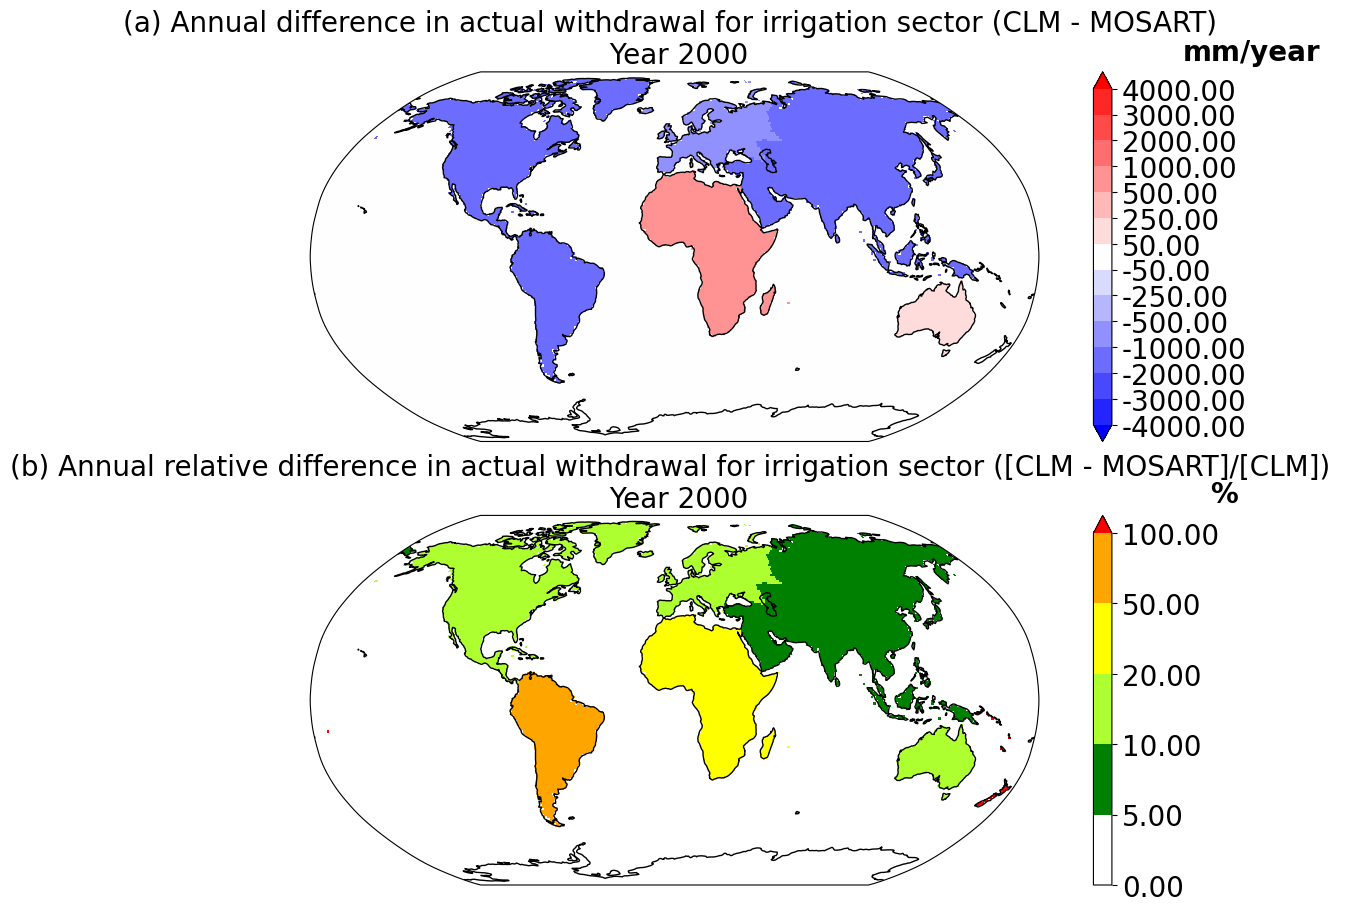

In [160]:
# Visualize the absolute and relative difference in total irrigation withdrawal:

# Prepare projection
data_crs = ccrs.PlateCarree()
projection = ccrs.Robinson()
# Prepare colormap
cmap =plt.cm.bwr
cmap2 = mpl.colors.ListedColormap(['white', 'green', 'greenyellow','yellow', 'orange', 'red'])

# Plot annual actual withdrawal for all sectors:
fig, axarr = plt.subplots(nrows=2, ncols=1, figsize=(6.6*3.7*1.2, 4.4*2*1.2), constrained_layout=False, subplot_kw={'projection': projection})
axlist = axarr.flatten()

for ax in axlist:
    ax.coastlines()




bounds = [-4000,-3000,-2000, -1000, -500, -250, -50, 50, 250, 500, 1000, 2000, 3000, 4000]
ticks  = [-4000,-3000,-2000, -1000, -500, -250, -50, 50, 250, 500, 1000, 2000, 3000, 4000]
norm   = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

bounds2 = [0.0, 5.0, 10, 20, 50, 100]
ticks2  = [0.0, 5.0, 10, 20, 50, 100]
norm2   = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='max')

map1 = axlist[0].pcolormesh(lnd_lon, lnd_lat, delta_irrig_lnd_vs_rof, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)
axlist[0].set_title('(a) Annual difference in actual withdrawal for irrigation sector (CLM - MOSART) \n Year 2000', fontsize=20)

map2 = axlist[1].pcolormesh(lnd_lon, lnd_lat, np.abs(relative_delta_irrig_lnd_vs_rof), cmap=cmap2, norm=norm2, transform=ccrs.PlateCarree(), rasterized=True)
axlist[1].set_title('(b) Annual relative difference in actual withdrawal for irrigation sector ([CLM - MOSART]/[CLM]) \n Year 2000', fontsize=20)


cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axarr[0], orientation='vertical', ticks=ticks, fraction=0.05,  pad=0.024, format='%.2f')
cb.set_label('mm/year', size=20, weight='bold', rotation=0, y=1.15)
cb.ax.tick_params(labelsize=20)


cb2 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm2, cmap=cmap2), ax=axarr[1], orientation='vertical', ticks=ticks2, fraction=0.05,  pad=0.024, format='%.2f')
cb2.set_label('%', size=20, weight='bold', rotation=0, y=1.15)
cb2.ax.tick_params(labelsize=20)

# Possible issue: in the ROF component we have two outputs for irrigation withdrawal fluxes:
1) The version received from the coupler, which cannot be changed (QIRRIG_FROM_COUPLER)
2) And one that can be apdated after checking again that there is enough water to avoid negative VOLR (QIRRIG_ACTUAL). If VOLR is not enough, water may be taken from the Ocean, but in this case QIRRIG_ACTUAL value will become lower than QIRRIG_FROM_COUPLER.

This can potentially explain the positive absolute difference (LND-ROF) we have see for Africa and Australia (see figure above [a]).
In order to check this, it suffices to compare total withdrawal from QIRRIG_FROM_COUPLER and QIRRIG_ACTUAL outputs.

In [162]:
# Load the irrigation data from routing model (mosart), but this time the QIRRIG_FROM_COUPLER
# The data is obtained from a simulation with: irrigate=.true. and limit_irrigation_if_rof_enabled=.true.
rof_irrig_withd_from_coupler = xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/rof/hist/selected_data/aggregated_data/selected_variables.ctsm_escomp_irrig_rof_limited.mosart.h0.2000.nc', decode_times=False)['QIRRIG_FROM_COUPLER'].sum(dim='time')

# Transform from m3/s to mm/year
# We get mm/year instead of mm/month because in the previous step we do the sum over 12 months of year 2000
rof_irrig_withd_from_coupler.values = (rof_irrig_withd_from_coupler.values.flatten()*rof_m3_per_s_to_mm_per_s*mm_per_s_to_mm_per_month).reshape((rof_lat.shape[0], rof_lon.shape[0]))


In [163]:
# Compare global actual and from the coupler irrigation withdrawal (ROF component)
print("Global actual irrigation withdrawal [ROF]: " + str(np.round(np.nansum(rof_irrig_withd),0)) + " mm/year")
print("Global irrigation withdrawal from the coupler [ROF]: " + str(np.round(np.nansum(rof_irrig_withd_from_coupler),0)) + " mm/year")

Global actual irrigation withdrawal [ROF]: -53534.0 mm/year
Global irrigation withdrawal from the coupler [ROF]: -53534.0 mm/year


# Conclusion actual vs coupling withdrawal:
We have the same amount between actual and from the coupler irrigation withdrawal.
The problem, if it exists, should be somewhere in the coupling process or in the LND component.

# Potential ideas why we have this issue:
1) QIRRIG_FROM_SURFACE (from LND component) is the output from the variable qflx_sfc_irrig_col:
        call hist_addfld1d ( &
         fname=this%info%fname('QIRRIG_FROM_SURFACE'), &
         units='mm/s', &
         avgflag='A', &
         long_name=this%info%lname('water added through surface water irrigation'), &
         ptr_col=this%qflx_sfc_irrig_col)
    
    At the same time, the variable which send through the coupler is qirrig_grc computed as follow:

    call c2g( bounds, &
             water_inst%waterfluxbulk_inst%qflx_sfc_irrig_col (bounds%begc:bounds%endc), &
             water_inst%waterlnd2atmbulk_inst%qirrig_grc(bounds%begg:bounds%endg), &
             c2l_scale_type= 'urbanf', l2g_scale_type='unity' )
             
             
    While I didn't check, the exact working of these subroutines, I expect the c2g (column to gridcell transition) to be conservative, so qirrig_grc should correctly represent qflx_sfc_irrig_col at gridcell level.
    And I also suppose that when we do hist_addfld1d with avgflag='A' the column array qflx_sfc_irrig_col will pass through c2g() operation too? 
    If both these statements are true, then this should not be the issue.

2)  Imprecise ROF areatotal2 computation. In order to transform the units of withdrawal from m3/s in ROF to mm/s, we need to divide by the area over which these fluxes are distributed (areatotal2 corresponding to computed basin upstream areatotal).
    I didn't looked into details here, but this may be an easy explanation. If this is the problem, and it only manifest when I try to do the conversion of units, then it is possible that we don't have a problem at all.
    Is there a good to check if this is the problem?

3)  Another potential issue could be related to the different coupling frequency between LND and ROF components. While I doubt it, since the VOLR_LND and VORL_ROF are specifically made consistent for the remaping process.
    But still is a good idea to check. For this I did an experiment where I changed ROF_NCPL to be the same as LND_NCPL. I will not show the results as the difference between the simulations were insignificant (about 0.1% change in total withdrawal)



# How other sectors are affected?
To answer this question we have made a simulation with sectoral water abstractions activated and limited their withdrawal based on available water in the river network.

The user namelist for this run is: 
irrigate=.false.
sectorwater=.true.
limit_sectorwater_if_rof_enabled = .false.

In [164]:
# Load the domestic withdrawal data:
lnd_dom_withd = (xr.open_dataset('/glade/scratch/staranu/archive/ctsm_for_pull_request_test1_2/lnd/hist/selected_data/aggregated_data/monthly/selected_variables.ctsm_escomp_irrig_rof_limited.clm2.h0.2000.nc', decode_times=False)['DOM_ACTUAL_WITHD']*mm_per_s_to_mm_per_month).sum(dim='time')
rof_dom_withd =  xr.open_dataset('/glade/scratch/staranu/archive/ctsm_for_pull_request_test1_2/rof/hist/selected/aggregated/mon/selected_variables.ctsm_escomp_irrig_rof_limited.mosart.h0.2000.nc', decode_times=False)['QDOM_ACTUAL_WITHD'].sum(dim='time')

# Transform from m3/s to mm/year
# We get mm/year instead of mm/month because in the previous step we do the sum over 12 months of year 2000
rof_dom_withd.values = (rof_dom_withd.values.flatten()*rof_m3_per_s_to_mm_per_s*mm_per_s_to_mm_per_month).reshape((rof_lat.shape[0], rof_lon.shape[0]))


In [173]:
# Comparison at continent level

file = pooch.retrieve(
    "https://pubs.usgs.gov/of/2006/1187/basemaps/continents/continents.zip", None
)

continents = gp.read_file("zip://" + file)

# Initialize some xarrays used for storage and computation
delta_dom_lnd_vs_rof = lnd_dom_withd.copy(deep=True)*0.0
relative_delta_dom_lnd_vs_rof = lnd_dom_withd.copy(deep=True)*0.0
array_ones = lnd_dom_withd.copy(deep=True)*0.0 + 1.0

# Generate a mask for each continent for both lnd and rof components
continents_lnd = regionmask.mask_geopandas(continents, lnd_lon, lnd_lat)
continents_rof = regionmask.mask_geopandas(continents, rof_lon, rof_lat)

# Each continent gets has its own individual index from 0 to 7
continent_index = np.arange(0,8)

# Comparison at continent level
# Find the absolute and relative difference in domestic withdrawal amount between lnd and routing component at each basin level
for continent in range(np.max(continent_index)+1): # loop over each continent
    continent_lnd_dom_withd = np.nansum(lnd_dom_withd.where(continents_lnd == continent)) # for given continent compute total withdrawal for LND component
    continent_rof_dom_withd = (-1.0)*np.nansum(rof_dom_withd.where(continents_rof == continent)) # for given continent compute total withdrawal for ROF component
    
    if continent != 7: # no withdrawal in Antarctica
        print("For " + str(continents.CONTINENT[continent]) + " total lnd domestic withdrawal is " + str(np.round(continent_lnd_dom_withd,0)) + " mm/year, while total rof domestic withdrawal is " + str(np.round(continent_rof_dom_withd,0)) + " mm/year.")
    
    delta = continent_lnd_dom_withd - continent_rof_dom_withd # compute absolute difference in withdrawal amount for given continent
    delta_dom_lnd_vs_rof = delta_dom_lnd_vs_rof + (array_ones.where(continents_lnd == continent)*delta).fillna(0) # add this continent difference in withdrawal to the map (masked by continent map)
    
    if continent != 7: # no withdrawal in Antarctica
        relative_delta_dom_lnd_vs_rof = relative_delta_dom_lnd_vs_rof + (array_ones.where(continents_lnd == continent)*(delta/continent_lnd_dom_withd)*100).fillna(0) # compute relative difference for given continent and add its value to the final map
      
    if continent != 7: # no withdrawal in Antarctica   
        print("Absolute difference is [LND - ROF]: " + str(np.round(delta,0)) + " mm/year")
        print("Relative difference is: [LND - ROF]/[LND]: " + str(np.round(np.abs((delta/continent_lnd_dom_withd)*100),1)) + " %")
        print()

print("For the entire globe, total lnd domestic withdrawal is " + str(np.round(np.nansum(lnd_dom_withd),0)) + " mm/year, while total rof domestic withdrawal is " + str(np.round(np.abs(np.nansum(rof_dom_withd)),0)) + " mm/year.")
print("Absolute difference is [LND - ROF]: " + str(np.round(np.nansum(lnd_dom_withd) - np.abs(np.nansum(rof_dom_withd)),0)) + " mm/year")
print("Relative difference is: [LND - ROF]/[LND]: " + str(np.round(np.abs((np.nansum(lnd_dom_withd) - np.abs(np.nansum(rof_dom_withd)))/np.nansum(lnd_dom_withd))*100,1)) + " %")
print()

For Asia total lnd domestic withdrawal is 12603.0 mm/year, while total rof domestic withdrawal is 16607.0 mm/year.
Absolute difference is [LND - ROF]: -4004.0 mm/year
Relative difference is: [LND - ROF]/[LND]: 31.8 %

For North America total lnd domestic withdrawal is 6236.0 mm/year, while total rof domestic withdrawal is 9421.0 mm/year.
Absolute difference is [LND - ROF]: -3186.0 mm/year
Relative difference is: [LND - ROF]/[LND]: 51.1 %

For Europe total lnd domestic withdrawal is 6803.0 mm/year, while total rof domestic withdrawal is 9806.0 mm/year.
Absolute difference is [LND - ROF]: -3004.0 mm/year
Relative difference is: [LND - ROF]/[LND]: 44.2 %

For Africa total lnd domestic withdrawal is 1770.0 mm/year, while total rof domestic withdrawal is 2782.0 mm/year.
Absolute difference is [LND - ROF]: -1011.0 mm/year
Relative difference is: [LND - ROF]/[LND]: 57.1 %

For South America total lnd domestic withdrawal is 1909.0 mm/year, while total rof domestic withdrawal is 3186.0 mm/year.

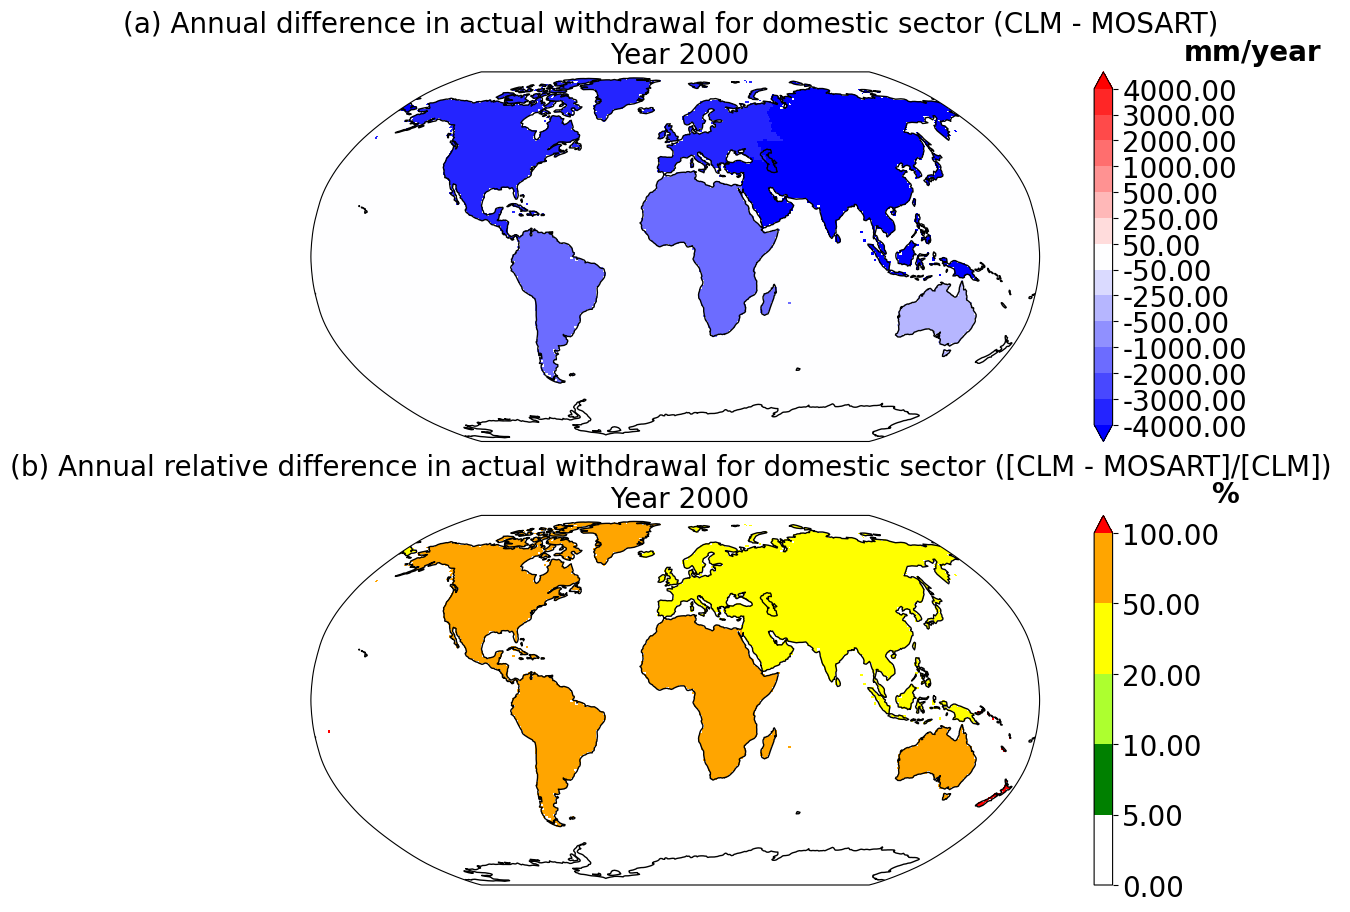

In [174]:
# Visualize the absolute and relative difference in total domestic withdrawal:

# Prepare projection
data_crs = ccrs.PlateCarree()
projection = ccrs.Robinson()
# Prepare colormap
cmap =plt.cm.bwr
cmap2 = mpl.colors.ListedColormap(['white', 'green', 'greenyellow','yellow', 'orange', 'red'])

# Plot annual actual withdrawal for all sectors:
fig, axarr = plt.subplots(nrows=2, ncols=1, figsize=(6.6*3.7*1.2, 4.4*2*1.2), constrained_layout=False, subplot_kw={'projection': projection})
axlist = axarr.flatten()

for ax in axlist:
    ax.coastlines()




bounds = [-4000,-3000,-2000, -1000, -500, -250, -50, 50, 250, 500, 1000, 2000, 3000, 4000]
ticks  = [-4000,-3000,-2000, -1000, -500, -250, -50, 50, 250, 500, 1000, 2000, 3000, 4000]
norm   = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

bounds2 = [0.0, 5.0, 10, 20, 50, 100]
ticks2  = [0.0, 5.0, 10, 20, 50, 100]
norm2   = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='max')

map1 = axlist[0].pcolormesh(lnd_lon, lnd_lat, delta_dom_lnd_vs_rof, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)
axlist[0].set_title('(a) Annual difference in actual withdrawal for domestic sector (CLM - MOSART) \n Year 2000', fontsize=20)

map2 = axlist[1].pcolormesh(lnd_lon, lnd_lat, np.abs(relative_delta_dom_lnd_vs_rof), cmap=cmap2, norm=norm2, transform=ccrs.PlateCarree(), rasterized=True)
axlist[1].set_title('(b) Annual relative difference in actual withdrawal for domestic sector ([CLM - MOSART]/[CLM]) \n Year 2000', fontsize=20)


cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axarr[0], orientation='vertical', ticks=ticks, fraction=0.05,  pad=0.024, format='%.2f')
cb.set_label('mm/year', size=20, weight='bold', rotation=0, y=1.15)
cb.ax.tick_params(labelsize=20)


cb2 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm2, cmap=cmap2), ax=axarr[1], orientation='vertical', ticks=ticks2, fraction=0.05,  pad=0.024, format='%.2f')
cb2.set_label('%', size=20, weight='bold', rotation=0, y=1.15)
cb2.ax.tick_params(labelsize=20)

In [140]:
# Load the livestock withdrawal data:
lnd_liv_withd = (xr.open_dataset('/glade/scratch/staranu/archive/ctsm_for_pull_request_test1_2/lnd/hist/selected_data/aggregated_data/monthly/selected_variables.ctsm_escomp_irrig_rof_limited.clm2.h0.2000.nc', decode_times=False)['LIV_ACTUAL_WITHD']*mm_per_s_to_mm_per_month).sum(dim='time')
rof_liv_withd =  xr.open_dataset('/glade/scratch/staranu/archive/ctsm_for_pull_request_test1_2/rof/hist/selected/aggregated/mon/selected_variables.ctsm_escomp_irrig_rof_limited.mosart.h0.2000.nc', decode_times=False)['QLIV_ACTUAL_WITHD'].sum(dim='time')

# Transform from m3/s to mm/year
# We get mm/year instead of mm/month because in the previous step we do the sum over 12 months of year 2000
rof_liv_withd.values = (rof_liv_withd.values.flatten()*rof_m3_per_s_to_mm_per_s*mm_per_s_to_mm_per_month).reshape((rof_lat.shape[0], rof_lon.shape[0]))


In [175]:
# Comparison at continent level

file = pooch.retrieve(
    "https://pubs.usgs.gov/of/2006/1187/basemaps/continents/continents.zip", None
)

continents = gp.read_file("zip://" + file)

# Initialize some xarrays used for storage and computation
delta_liv_lnd_vs_rof = lnd_liv_withd.copy(deep=True)*0.0
relative_delta_liv_lnd_vs_rof = lnd_liv_withd.copy(deep=True)*0.0
array_ones = lnd_liv_withd.copy(deep=True)*0.0 + 1.0

# Generate a mask for each continent for both lnd and rof components
continents_lnd = regionmask.mask_geopandas(continents, lnd_lon, lnd_lat)
continents_rof = regionmask.mask_geopandas(continents, rof_lon, rof_lat)

# Each continent gets has its own individual index from 0 to 7
continent_index = np.arange(0,8)

# Comparison at continent level
# Find the absolute and relative difference in livestock withdrawal amount between lnd and routing component at each basin level
for continent in range(np.max(continent_index)+1): # loop over each continent
    continent_lnd_liv_withd = np.nansum(lnd_liv_withd.where(continents_lnd == continent)) # for given continent compute total withdrawal for LND component
    continent_rof_liv_withd = (-1.0)*np.nansum(rof_liv_withd.where(continents_rof == continent)) # for given continent compute total withdrawal for ROF component
    
    if continent != 7: # no withdrawal in Antarctica
        print("For " + str(continents.CONTINENT[continent]) + " total lnd livestock withdrawal is " + str(np.round(continent_lnd_liv_withd,0)) + " mm/year, while total rof livestock withdrawal is " + str(np.round(continent_rof_liv_withd,0)) + " mm/year.")
    
    delta = continent_lnd_liv_withd - continent_rof_liv_withd # compute absolute difference in withdrawal amount for given continent
    delta_liv_lnd_vs_rof = delta_liv_lnd_vs_rof + (array_ones.where(continents_lnd == continent)*delta).fillna(0) # add this continent difference in withdrawal to the map (masked by continent map)
    
    if continent != 7: # no withdrawal in Antarctica
        relative_delta_liv_lnd_vs_rof = relative_delta_liv_lnd_vs_rof + (array_ones.where(continents_lnd == continent)*(delta/continent_lnd_liv_withd)*100).fillna(0) # compute relative difference for given continent and add its value to the final map
      
    if continent != 7: # no withdrawal in Antarctica   
        print("Absolute difference is [LND - ROF]: " + str(np.round(delta,0)) + " mm/year")
        print("Relative difference is: [LND - ROF]/[LND]: " + str(np.round(np.abs((delta/continent_lnd_liv_withd)*100),1)) + " %")
        print()
        
print("For the entire globe, total lnd livestock withdrawal is " + str(np.round(np.nansum(lnd_liv_withd),0)) + " mm/year, while total rof livestock withdrawal is " + str(np.round(np.abs(np.nansum(rof_liv_withd)),0)) + " mm/year.")
print("Absolute difference is [LND - ROF]: " + str(np.round(np.nansum(lnd_liv_withd) - np.abs(np.nansum(rof_liv_withd)),0)) + " mm/year")
print("Relative difference is: [LND - ROF]/[LND]: " + str(np.round(np.abs((np.nansum(lnd_liv_withd) - np.abs(np.nansum(rof_liv_withd)))/np.nansum(lnd_liv_withd))*100,1)) + " %")
print()

For Asia total lnd livestock withdrawal is 4437.0 mm/year, while total rof livestock withdrawal is 5563.0 mm/year.
Absolute difference is [LND - ROF]: -1126.0 mm/year
Relative difference is: [LND - ROF]/[LND]: 25.4 %

For North America total lnd livestock withdrawal is 1063.0 mm/year, while total rof livestock withdrawal is 1416.0 mm/year.
Absolute difference is [LND - ROF]: -352.0 mm/year
Relative difference is: [LND - ROF]/[LND]: 33.1 %

For Europe total lnd livestock withdrawal is 859.0 mm/year, while total rof livestock withdrawal is 1320.0 mm/year.
Absolute difference is [LND - ROF]: -461.0 mm/year
Relative difference is: [LND - ROF]/[LND]: 53.6 %

For Africa total lnd livestock withdrawal is 725.0 mm/year, while total rof livestock withdrawal is 824.0 mm/year.
Absolute difference is [LND - ROF]: -99.0 mm/year
Relative difference is: [LND - ROF]/[LND]: 13.7 %

For South America total lnd livestock withdrawal is 551.0 mm/year, while total rof livestock withdrawal is 1111.0 mm/year.

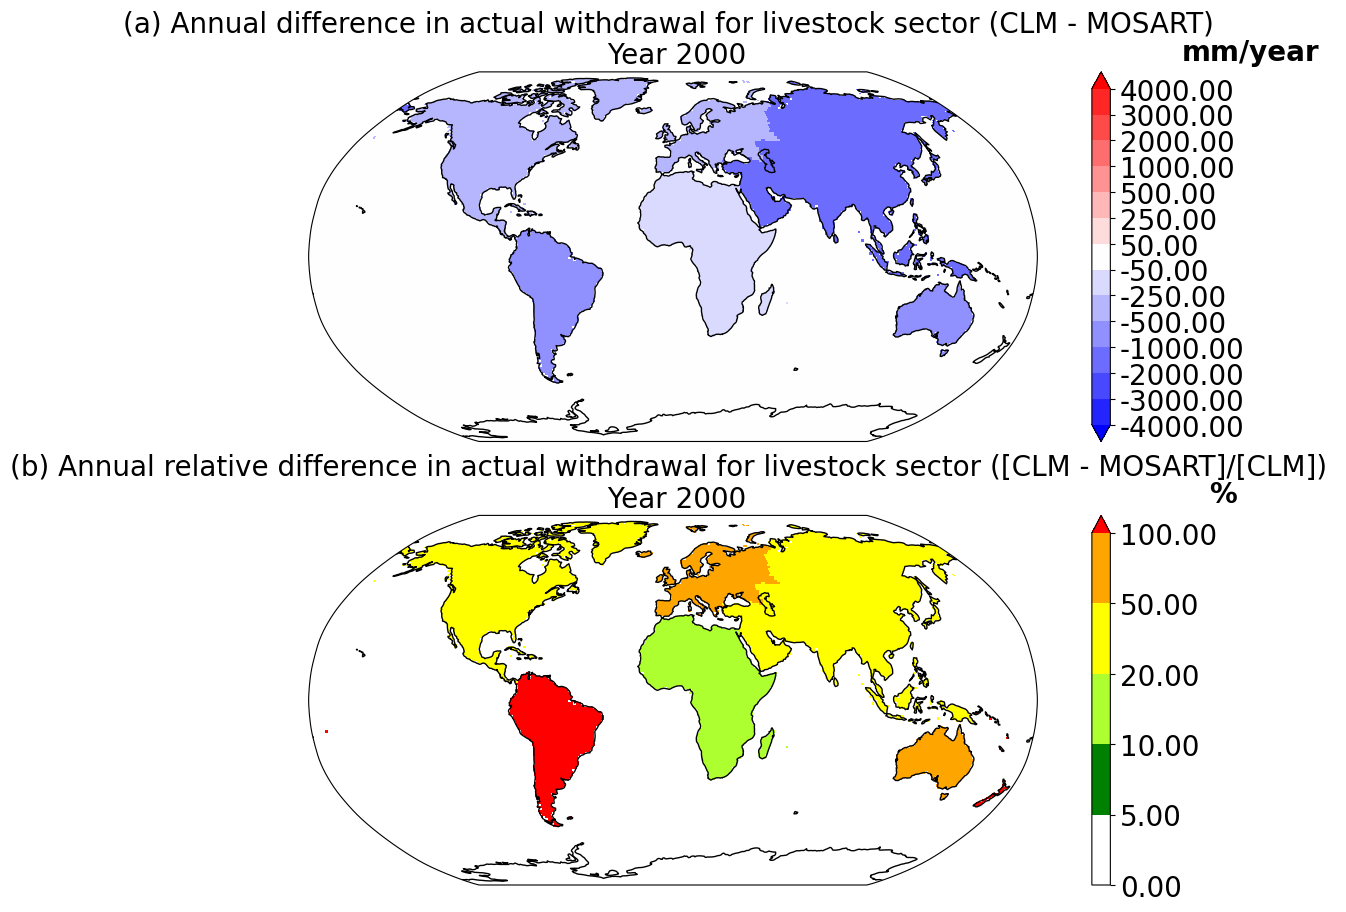

In [176]:
# Visualize the absolute and relative difference in total livestock withdrawal:

# Prepare projection
data_crs = ccrs.PlateCarree()
projection = ccrs.Robinson()
# Prepare colormap
cmap =plt.cm.bwr
cmap2 = mpl.colors.ListedColormap(['white', 'green', 'greenyellow','yellow', 'orange', 'red'])

# Plot annual actual withdrawal for all sectors:
fig, axarr = plt.subplots(nrows=2, ncols=1, figsize=(6.6*3.7*1.2, 4.4*2*1.2), constrained_layout=False, subplot_kw={'projection': projection})
axlist = axarr.flatten()

for ax in axlist:
    ax.coastlines()




bounds = [-4000,-3000,-2000, -1000, -500, -250, -50, 50, 250, 500, 1000, 2000, 3000, 4000]
ticks  = [-4000,-3000,-2000, -1000, -500, -250, -50, 50, 250, 500, 1000, 2000, 3000, 4000]
norm   = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

bounds2 = [0.0, 5.0, 10, 20, 50, 100]
ticks2  = [0.0, 5.0, 10, 20, 50, 100]
norm2   = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='max')

map1 = axlist[0].pcolormesh(lnd_lon, lnd_lat, delta_liv_lnd_vs_rof, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)
axlist[0].set_title('(a) Annual difference in actual withdrawal for livestock sector (CLM - MOSART) \n Year 2000', fontsize=20)

map2 = axlist[1].pcolormesh(lnd_lon, lnd_lat, np.abs(relative_delta_liv_lnd_vs_rof), cmap=cmap2, norm=norm2, transform=ccrs.PlateCarree(), rasterized=True)
axlist[1].set_title('(b) Annual relative difference in actual withdrawal for livestock sector ([CLM - MOSART]/[CLM]) \n Year 2000', fontsize=20)


cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axarr[0], orientation='vertical', ticks=ticks, fraction=0.05,  pad=0.024, format='%.2f')
cb.set_label('mm/year', size=20, weight='bold', rotation=0, y=1.15)
cb.ax.tick_params(labelsize=20)


cb2 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm2, cmap=cmap2), ax=axarr[1], orientation='vertical', ticks=ticks2, fraction=0.05,  pad=0.024, format='%.2f')
cb2.set_label('%', size=20, weight='bold', rotation=0, y=1.15)
cb2.ax.tick_params(labelsize=20)

In [178]:
# Load the thermoelectric withdrawal data:
lnd_elec_withd = (xr.open_dataset('/glade/scratch/staranu/archive/ctsm_for_pull_request_test1_2/lnd/hist/selected_data/aggregated_data/monthly/selected_variables.ctsm_escomp_irrig_rof_limited.clm2.h0.2000.nc', decode_times=False)['ELEC_ACTUAL_WITHD']*mm_per_s_to_mm_per_month).sum(dim='time')
rof_elec_withd =  xr.open_dataset('/glade/scratch/staranu/archive/ctsm_for_pull_request_test1_2/rof/hist/selected/aggregated/mon/selected_variables.ctsm_escomp_irrig_rof_limited.mosart.h0.2000.nc', decode_times=False)['QELEC_ACTUAL_WITHD'].sum(dim='time')

# Transform from m3/s to mm/year
# We get mm/year instead of mm/month because in the previous step we do the sum over 12 months of year 2000
rof_elec_withd.values = (rof_elec_withd.values.flatten()*rof_m3_per_s_to_mm_per_s*mm_per_s_to_mm_per_month).reshape((rof_lat.shape[0], rof_lon.shape[0]))


In [180]:
# Comparison at continent level

file = pooch.retrieve(
    "https://pubs.usgs.gov/of/2006/1187/basemaps/continents/continents.zip", None
)

continents = gp.read_file("zip://" + file)

# Initialize some xarrays used for storage and computation
delta_elec_lnd_vs_rof = lnd_elec_withd.copy(deep=True)*0.0
relative_delta_elec_lnd_vs_rof = lnd_elec_withd.copy(deep=True)*0.0
array_ones = lnd_elec_withd.copy(deep=True)*0.0 + 1.0

# Generate a mask for each continent for both lnd and rof components
continents_lnd = regionmask.mask_geopandas(continents, lnd_lon, lnd_lat)
continents_rof = regionmask.mask_geopandas(continents, rof_lon, rof_lat)

# Each continent gets has its own individual index from 0 to 7
continent_index = np.arange(0,8)

# Comparison at continent level
# Find the absolute and relative difference in thermoelectric withdrawal amount between lnd and routing component at each basin level
for continent in range(np.max(continent_index)+1): # loop over each continent
    continent_lnd_elec_withd = np.nansum(lnd_elec_withd.where(continents_lnd == continent)) # for given continent compute total withdrawal for LND component
    continent_rof_elec_withd = (-1.0)*np.nansum(rof_elec_withd.where(continents_rof == continent)) # for given continent compute total withdrawal for ROF component
    
    if continent != 7: # no withdrawal in Antarctica
        print("For " + str(continents.CONTINENT[continent]) + " total lnd thermoelectric withdrawal is " + str(np.round(continent_lnd_elec_withd,0)) + " mm/year, while total rof thermoelectric withdrawal is " + str(np.round(continent_rof_elec_withd,0)) + " mm/year.")
    
    delta = continent_lnd_elec_withd - continent_rof_elec_withd # compute absolute difference in withdrawal amount for given continent
    delta_elec_lnd_vs_rof = delta_elec_lnd_vs_rof + (array_ones.where(continents_lnd == continent)*delta).fillna(0) # add this continent difference in withdrawal to the map (masked by continent map)
    
    if continent != 7: # no withdrawal in Antarctica
        relative_delta_elec_lnd_vs_rof = relative_delta_elec_lnd_vs_rof + (array_ones.where(continents_lnd == continent)*(delta/continent_lnd_elec_withd)*100).fillna(0) # compute relative difference for given continent and add its value to the final map
      
    if continent != 7: # no withdrawal in Antarctica   
        print("Absolute difference is [LND - ROF]: " + str(np.round(delta,0)) + " mm/year")
        print("Relative difference is: [LND - ROF]/[LND]: " + str(np.round(np.abs((delta/continent_lnd_elec_withd)*100),1)) + " %")
        print()
        
print("For the entire globe, total lnd thermoelectric withdrawal is " + str(np.round(np.nansum(lnd_elec_withd),0)) + " mm/year, while total rof thermoelectric withdrawal is " + str(np.round(np.abs(np.nansum(rof_elec_withd)),0)) + " mm/year.")
print("Absolute difference is [LND - ROF]: " + str(np.round(np.nansum(lnd_elec_withd) - np.abs(np.nansum(rof_elec_withd)),0)) + " mm/year")
print("Relative difference is: [LND - ROF]/[LND]: " + str(np.round(np.abs((np.nansum(lnd_elec_withd) - np.abs(np.nansum(rof_elec_withd)))/np.nansum(lnd_elec_withd))*100,1)) + " %")
print()  

For Asia total lnd thermoelectric withdrawal is 8028.0 mm/year, while total rof thermoelectric withdrawal is 9041.0 mm/year.
Absolute difference is [LND - ROF]: -1013.0 mm/year
Relative difference is: [LND - ROF]/[LND]: 12.6 %

For North America total lnd thermoelectric withdrawal is 18485.0 mm/year, while total rof thermoelectric withdrawal is 24238.0 mm/year.
Absolute difference is [LND - ROF]: -5753.0 mm/year
Relative difference is: [LND - ROF]/[LND]: 31.1 %

For Europe total lnd thermoelectric withdrawal is 10848.0 mm/year, while total rof thermoelectric withdrawal is 13958.0 mm/year.
Absolute difference is [LND - ROF]: -3110.0 mm/year
Relative difference is: [LND - ROF]/[LND]: 28.7 %

For Africa total lnd thermoelectric withdrawal is 278.0 mm/year, while total rof thermoelectric withdrawal is 355.0 mm/year.
Absolute difference is [LND - ROF]: -77.0 mm/year
Relative difference is: [LND - ROF]/[LND]: 27.7 %

For South America total lnd thermoelectric withdrawal is 214.0 mm/year, whi

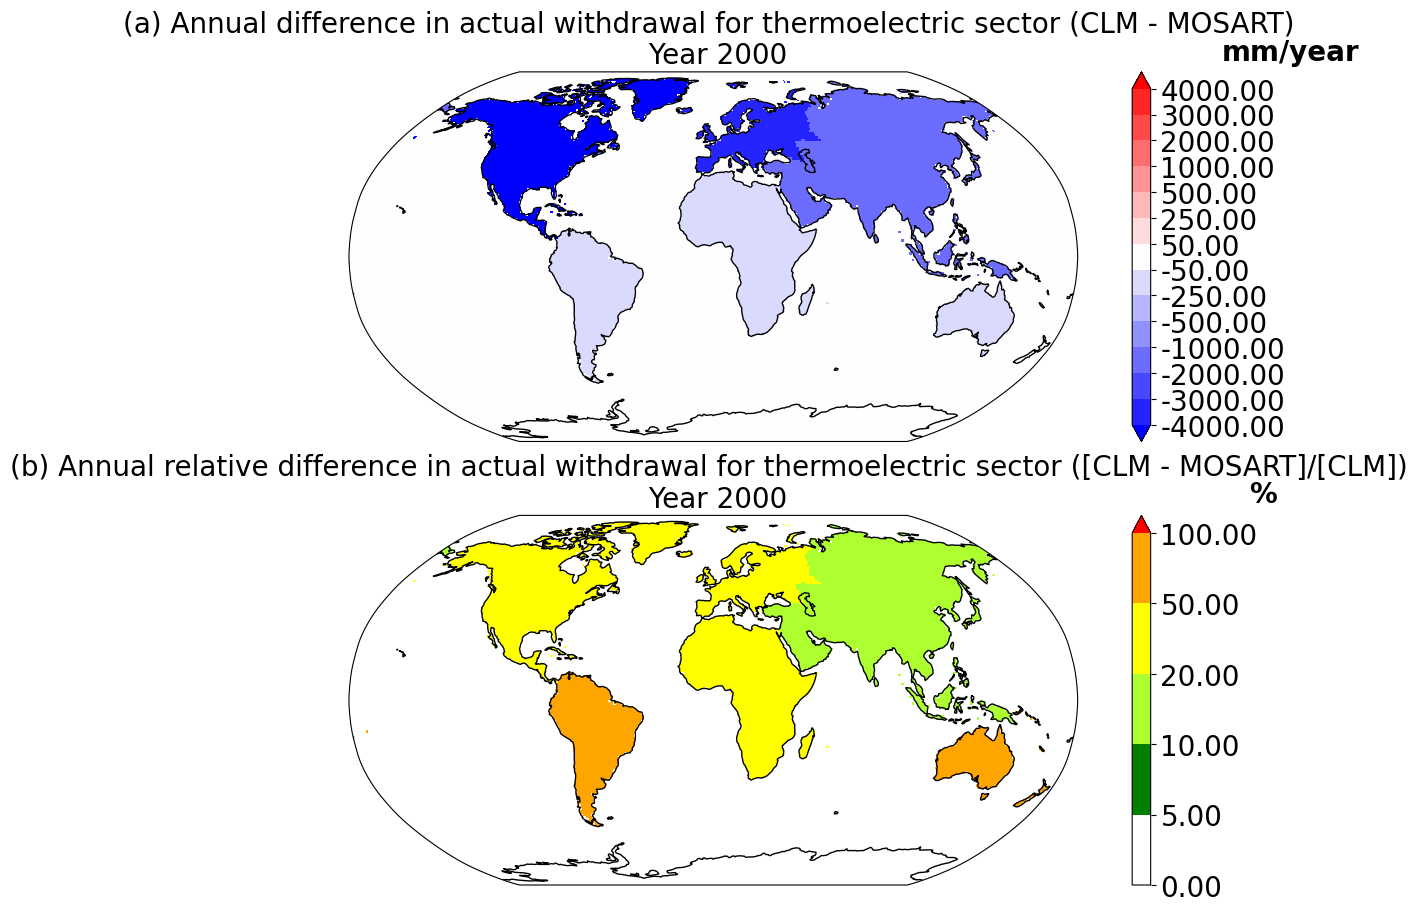

In [181]:
# Visualize the absolute and relative difference in total thermoelectric withdrawal:

# Prepare projection
data_crs = ccrs.PlateCarree()
projection = ccrs.Robinson()
# Prepare colormap
cmap =plt.cm.bwr
cmap2 = mpl.colors.ListedColormap(['white', 'green', 'greenyellow','yellow', 'orange', 'red'])

# Plot annual actual withdrawal for all sectors:
fig, axarr = plt.subplots(nrows=2, ncols=1, figsize=(6.6*3.7*1.2, 4.4*2*1.2), constrained_layout=False, subplot_kw={'projection': projection})
axlist = axarr.flatten()

for ax in axlist:
    ax.coastlines()




bounds = [-4000,-3000,-2000, -1000, -500, -250, -50, 50, 250, 500, 1000, 2000, 3000, 4000]
ticks  = [-4000,-3000,-2000, -1000, -500, -250, -50, 50, 250, 500, 1000, 2000, 3000, 4000]
norm   = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

bounds2 = [0.0, 5.0, 10, 20, 50, 100]
ticks2  = [0.0, 5.0, 10, 20, 50, 100]
norm2   = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='max')

map1 = axlist[0].pcolormesh(lnd_lon, lnd_lat, delta_elec_lnd_vs_rof, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)
axlist[0].set_title('(a) Annual difference in actual withdrawal for thermoelectric sector (CLM - MOSART) \n Year 2000', fontsize=20)

map2 = axlist[1].pcolormesh(lnd_lon, lnd_lat, np.abs(relative_delta_elec_lnd_vs_rof), cmap=cmap2, norm=norm2, transform=ccrs.PlateCarree(), rasterized=True)
axlist[1].set_title('(b) Annual relative difference in actual withdrawal for thermoelectric sector ([CLM - MOSART]/[CLM]) \n Year 2000', fontsize=20)


cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axarr[0], orientation='vertical', ticks=ticks, fraction=0.05,  pad=0.024, format='%.2f')
cb.set_label('mm/year', size=20, weight='bold', rotation=0, y=1.15)
cb.ax.tick_params(labelsize=20)


cb2 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm2, cmap=cmap2), ax=axarr[1], orientation='vertical', ticks=ticks2, fraction=0.05,  pad=0.024, format='%.2f')
cb2.set_label('%', size=20, weight='bold', rotation=0, y=1.15)
cb2.ax.tick_params(labelsize=20)